<a href="https://colab.research.google.com/github/BhargavKilambi/sem-7/blob/master/proposed_with_aug.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### This is an implementation of CRNN over audio data ( 2sec snippets downsampled to mono (22050Hz)) with augmentation of data (adding noise)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp "drive/My Drive/AudPrep.zip" "AudPrep.zip"

In [3]:
!unzip "AudPrep.zip"

Archive:  AudPrep.zip
   creating: AudPrep/
   creating: AudPrep/cel/
  inflating: AudPrep/cel/008__[cel][nod][cla]0058__1.wav.npy  
  inflating: AudPrep/cel/008__[cel][nod][cla]0058__2.wav.npy  
  inflating: AudPrep/cel/008__[cel][nod][cla]0058__3.wav.npy  
  inflating: AudPrep/cel/012__[cel][nod][cla]0043__1.wav.npy  
  inflating: AudPrep/cel/012__[cel][nod][cla]0043__2.wav.npy  
  inflating: AudPrep/cel/012__[cel][nod][cla]0043__3.wav.npy  
  inflating: AudPrep/cel/013__[cel][nod][cla]0025__1.wav.npy  
  inflating: AudPrep/cel/013__[cel][nod][cla]0025__2.wav.npy  
  inflating: AudPrep/cel/013__[cel][nod][cla]0025__3.wav.npy  
  inflating: AudPrep/cel/014__[cel][nod][cla]0041__1.wav.npy  
  inflating: AudPrep/cel/014__[cel][nod][cla]0041__2.wav.npy  
  inflating: AudPrep/cel/014__[cel][nod][cla]0041__3.wav.npy  
  inflating: AudPrep/cel/027__[cel][nod][cla]0027__1.wav.npy  
  inflating: AudPrep/cel/027__[cel][nod][cla]0027__2.wav.npy  
  inflating: AudPrep/cel/027__[cel][nod][cla]002

In [0]:
import numpy as np
import os
import matplotlib.pyplot as plt
from os.path import isfile

In [2]:
from keras.layers import Conv2D,MaxPooling2D,Dropout,BatchNormalization,Dense,Activation,Flatten,GlobalMaxPooling2D,Reshape,TimeDistributed,LSTM,Permute
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.regularizers import l2

Using TensorFlow backend.


In [0]:
mono=True

# Get and return all the sub dir names ( == classes)
def get_class_names(path="AudPrep/"): 
    class_names = os.listdir(path)
    return class_names

def get_total_files(path="AudPrep/",train_percentage=0.8): 
    sum_total = 0
    sum_train = 0
    sum_test = 0
    subdirs = os.listdir(path)
    for subdir in subdirs:
        files = os.listdir(path+subdir)
        n_files = len(files)
        sum_total += n_files
        n_train = int(train_percentage*n_files)
        n_test = n_files - n_train
        sum_train += n_train
        sum_test += n_test
    return sum_total, sum_train, sum_test

def get_sample_dimensions(path="AudPrep/"):
    classname = os.listdir(path)[0]
    files = os.listdir(path+classname)
    infilename = files[0]
    audio_path = path + classname + '/' + infilename
    melgram = np.load(audio_path,allow_pickle=True)
    print("   get_sample_dimensions: melgram.shape = ",melgram.shape)
    return melgram.shape

In [0]:
# Manual version of normal tensorflow methods like train-test splitting and one-hot encoding

'''
--manual one-hot encoding--
1.get the index of the selected class name in the class names list
2.init a vector(list) of zeroes of length = no. of classes
3.set the value 1 at the index of selected class name
'''
def encode_class(class_name, class_names): 
    try:
        idx = class_names.index(class_name)
        vec = np.zeros(len(class_names))
        vec[idx] = 1
        return vec
    except ValueError:
        return None

# shuffle the X,Y (data and labels) to create randomness
def shuffle_XY_paths(X,Y,paths):
    assert (X.shape[0] == Y.shape[0] )
    idx = np.array(range(Y.shape[0]))
    np.random.shuffle(idx)
    newX = np.copy(X)
    newY = np.copy(Y)
    newpaths = paths
    for i in range(len(idx)):
        newX[i] = X[idx[i],:,:]
        newY[i] = Y[idx[i],:]
        newpaths[i] = paths[idx[i]]
    return newX, newY, newpaths


In [5]:
mel_dims = get_sample_dimensions(path="AudPrep/")

   get_sample_dimensions: melgram.shape =  (1, 128, 259, 1)


In [0]:
def build_datasets(train_percentage=0.75, preproc=False):
    if (preproc):
        path = "AudPrep/"
    else:
        path = "IRMAS-TrainingData/"

    class_names = get_class_names(path=path)
    print("class_names = ",class_names)

    total_files, total_train, total_test = get_total_files(path=path, train_percentage=train_percentage)
    print("total files = ",total_files)
    print(total_train,total_test)
    nb_classes = len(class_names)
    mel_dims = get_sample_dimensions(path=path)  # Find out the 'shape' of each data file
    ran_len = int((total_train * 0.35)//1.)
    X_train = np.zeros(((total_train + ran_len), mel_dims[1], mel_dims[2], mel_dims[3]))   
    Y_train = np.zeros(((total_train + ran_len), nb_classes))  
    X_test = np.zeros(((total_test), mel_dims[1], mel_dims[2], mel_dims[3]))  
    Y_test = np.zeros(((total_test), nb_classes))  
    paths_train = []
    paths_test = []
    print(len(X_train))
    train_count = 0
    test_count = 0
    ran_count = 0
    temp_flag = 0
    for idx, classname in enumerate(class_names):
        this_Y = np.array(encode_class(classname,class_names) )
        this_Y = this_Y[np.newaxis,:]
        class_files = os.listdir(path+classname)
        n_files = len(class_files)
        n_load =  n_files
        n_train = int(train_percentage * n_load)
        printevery = 100
        print("")
        for idx2, infilename in enumerate(class_files[0:n_load]):          
            audio_path = path + classname + '/' + infilename
            if (0 == idx2 % printevery):
                print('\r Loading class: {:14s} ({:2d} of {:2d} classes)'.format(classname,idx+1,nb_classes),
                       ", file ",idx2+1," of ",n_load,": ",audio_path,sep="")
            #start = timer()
            if (preproc):
              melgram = np.load(audio_path,allow_pickle=True)
              sr = 44100
            else:
              aud, sr = librosa.load(audio_path, mono=mono,sr=None)
              melgram = librosa.logamplitude(librosa.feature.melspectrogram(aud, sr=sr, n_mels=96),ref_power=1.0)[np.newaxis,np.newaxis,:,:]

            melgram = melgram[:,:,:,0:mel_dims[3]]   # just in case files are differnt sizes: clip to first file size
       
            
            if (idx2 < n_train):
                X_train[train_count,:,:] = melgram
                Y_train[train_count,:] = this_Y
                paths_train.append(audio_path)     
                train_count += 1

                # the augmentation part
                '''
                sparsely augmenting 35% of training data throughout the dataset
                out of 5024 snippets available for training - 1728 more are created through noise
                making it 6782 samples in total
                '''
                if train_count%2 == 0 and ran_count < ran_len:
                  paths_train.append(audio_path)
                  wn = np.random.randn(len(melgram))
                  data_wn = melgram + 0.008*wn
                  X_train[train_count,:,:] = data_wn
                  Y_train[train_count,:] = this_Y
                  train_count += 1
                  ran_count += 1
                
            else:
              # testing set it untouched 'cause we dont augment it
                X_test[test_count,:,:] = melgram
                Y_test[test_count,:] = this_Y
                paths_test.append(audio_path)
                test_count += 1
        print("")
    print("x train ",X_train.shape)
    print("y train ",Y_train.shape)
    print("y test ",X_test.shape)
    print("y train ",Y_test.shape)
    print("path train ",len(paths_train))
    print("path test ",len(paths_test))
    print("Shuffling order of data...")
    X_train, Y_train, paths_train = shuffle_XY_paths(X_train, Y_train, paths_train)
    X_test, Y_test, paths_test = shuffle_XY_paths(X_test, Y_test, paths_test)

    return X_train, Y_train, paths_train, X_test, Y_test, paths_test, class_names, sr

['org', 'voi', 'cel', 'gac', 'pia', 'flu', 'sax', 'vio', 'gel', 'tru', 'cla']

In [20]:
X_train, Y_train, paths_train, X_test, Y_test, paths_test, class_names, sr = build_datasets(preproc=True)

class_names =  ['org', 'voi', 'cel', 'gac', 'pia', 'flu', 'sax', 'vio', 'gel', 'tru', 'cla']
total files =  6705
5024 1681
   get_sample_dimensions: melgram.shape =  (1, 128, 259, 1)
6782

 Loading class: org            ( 1 of 11 classes), file 1 of 682: AudPrep/org/[org][pop_roc]1240__2.wav.npy
 Loading class: org            ( 1 of 11 classes), file 101 of 682: AudPrep/org/[org][jaz_blu]1084__2.wav.npy
 Loading class: org            ( 1 of 11 classes), file 201 of 682: AudPrep/org/[org][pop_roc]1142__3.wav.npy
 Loading class: org            ( 1 of 11 classes), file 301 of 682: AudPrep/org/[org][jaz_blu]1156__2.wav.npy
 Loading class: org            ( 1 of 11 classes), file 401 of 682: AudPrep/org/[org][jaz_blu]1261__3.wav.npy
 Loading class: org            ( 1 of 11 classes), file 501 of 682: AudPrep/org/[org][jaz_blu]1177__2.wav.npy
 Loading class: org            ( 1 of 11 classes), file 601 of 682: AudPrep/org/[org][pop_roc]1243__3.wav.npy


 Loading class: voi            ( 2 of 11 

In [16]:
X_train.shape

(6782, 128, 259, 1)

In [0]:
### augment only training set -- that too only some percentage of it
#wn = np.random.randn(len(melgram))
#data_wn = melgram + 0.008*wn
# import random
# def augment_training(X,Y):
#   total_len = X.shape[0]
#   ran_len = int((total_len * 0.35)//1.)
#   #new_train = np.zeros((ran_len,X.shape[1],X.shape[2],X.shape[3]))
#   new_train = np.zeros((ran_len,128,259,1))
#   new_y_train = np.zeros((ran_len,Y.shape[1]))
#   vals = random.sample(range(0,total_len),ran_len)
#   print(ran_len)
#   print('Creating {0} more random samples \n'.format(ran_len))
#   printevery = 25
#   count = 0
#   for idx,ind in enumerate(vals):
#     temp_data = X[ind]
#     wn = np.random.randn(len(temp_data))
#     y_noise = temp_data.copy()
#     noise_amp = 0.008*np.random.uniform()*np.amax(y_noise)
#     y_noise = y_noise.astype('float64') + noise_amp * np.random.normal(size=y_noise.shape[0])
#     curr_label = Y[ind]
#     new_train[count,:,:] = y_noise
#     new_y_train[count] = curr_label
#     count += 1
#     if count % 25 == 0:
#       print('{0} samples processed\n'.format(count))
#   return new_train,new_y_train
    
  

In [21]:
X_train.shape

(6782, 128, 259, 1)

In [0]:
split_index = int((X_test.shape[0] * 0.65) // 1)

In [0]:
# Splitting validation and testing data from the remaining 25%
X_test,Y_test,X_val,Y_val = X_test[:split_index,:,:,:],Y_test[:split_index,:],X_test[split_index:,:,:],Y_test[split_index:,:]

In [24]:
X_val.shape

(589, 128, 259, 1)

In [0]:
def build_model(X,nb_classes):
    pool_size = (3, 3)  # size of pooling area for max pooling
    kernel_size = (5, 5)  # convolution kernel size
    nb_layers = 6
    input_shape = (X.shape[1], X.shape[2], X.shape[3])

    model = Sequential()
    
    # 4 2D Convolution Layers
    model.add(Conv2D(64,input_shape=input_shape,kernel_size=kernel_size,kernel_regularizer=l2(0.01),bias_regularizer=l2(0.01),padding="same",activation="relu"))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64,kernel_size=kernel_size,kernel_regularizer=l2(0.01),bias_regularizer=l2(0.01),padding="same",activation="relu"))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128,kernel_size=kernel_size,kernel_regularizer=l2(0.01),bias_regularizer=l2(0.01),padding="same",activation="relu"))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128,kernel_size=kernel_size,kernel_regularizer=l2(0.01),bias_regularizer=l2(0.01),padding="same",activation="relu"))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    
    model.add(Permute((2,1,3)))
    
    last_shape = model.layers[-1].output_shape
    model.add(Reshape((last_shape[1],last_shape[2]*last_shape[3])))
    
    # 2 LSTM layers
    model.add(LSTM(32,kernel_regularizer=l2(0.01),recurrent_regularizer=l2(0.01),recurrent_dropout=0.5,return_sequences=True,go_backwards=False,activation='tanh'))
    model.add(LSTM(32,kernel_regularizer=l2(0.01),recurrent_regularizer=l2(0.01),recurrent_dropout=0.5,return_sequences=True,go_backwards=True,activation='tanh'))
    
    model.add(Dropout(0.25))
    
    #model.add(Flatten())
    model.add(TimeDistributed(Dense(128,activation='relu')))
    model.add(Dropout(0.5))
    
    model.add(TimeDistributed(Dense(64,activation='relu')))
    model.add(Dropout(0.5))
    
    model.add(Flatten())
    
    #relu throughout the network and softmax at output layer (multiple classes)
    model.add(Dense(nb_classes,activation='softmax'))
    return model

In [26]:
np.random.seed(20)

opt_adam = Adam(lr=0.0001, decay=1e-6, amsgrad=False)
# make the model
model = build_model(X_train,len(class_names))
model.compile(loss='categorical_crossentropy',
          optimizer=opt_adam,
          metrics=['accuracy'])
model.summary()


# Initialize weights using checkpoint if it exists. (Checkpointing requires h5py)
load_checkpoint = True
checkpoint_filepath = 'proposed_crnn_aug.hdf5'
if (load_checkpoint):
    print("Looking for previous weights...")
    if ( isfile(checkpoint_filepath) ):
        print ('Checkpoint file detected. Loading weights.')
        model.load_weights(checkpoint_filepath)
    else:
        print ('No checkpoint file detected.  Starting from scratch.')
else:
    print('Starting from scratch (no checkpoint)')
checkpointer = ModelCheckpoint(filepath=checkpoint_filepath, verbose=1, save_best_only=True)


# train and score the model
batch_size = 128
nb_epoch = 100
hist = model.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch,
      verbose=1, validation_data=(X_val, Y_val), callbacks=[checkpointer])
score = model.evaluate(X_test, Y_test, verbose=0)
model_name = 'proposed_model_aug.h5'
model.save(model_name)
print('Test score:', score[0])
print('Test accuracy:', score[1])













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 259, 64)      1664      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 42, 86, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 42, 86, 64)        256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 42, 86, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 42, 86, 64)        102464    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 28, 64)        0 

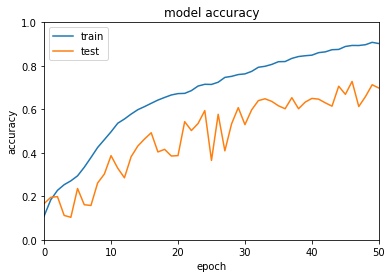

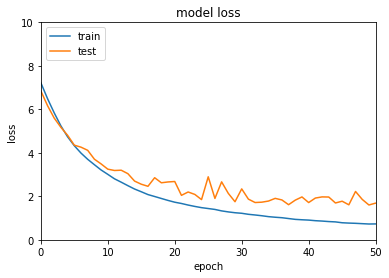

In [27]:
hist.history.keys()
history = hist
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.axis([0,50,0,1])
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.axis([0,50,0,10])
plt.show()

In [0]:
# load the model from weights and the model structure
# start from here if weights already attained after training
from keras.models import load_model
model1 = load_model('proposed_model_aug.h5')
model1.load_weights('proposed_crnn_aug.hdf5')

In [0]:
# to open a modeel stored in yaml file
model_yaml = model1.to_yaml()
with open("model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)

In [0]:
y_pred = model1.predict_classes(X_test)

In [0]:
y_pred1 = []
for j in y_pred:
  vec = np.zeros(11)
  ind = np.where(j == np.amax(j))
  vec[ind] = 1.
  y_pred1.append(vec)
  
y_pred1 = np.array(y_pred1)

In [0]:
y_test1 = []
for j in Y_test:
  ind = np.where(j == np.amax(j))
  y_test1.append(ind[0][0])

y_test1 = np.array(y_test1)

In [32]:
import sklearn.metrics as skm

cm = skm.confusion_matrix(y_test1, y_pred)
print(cm)
print( skm.classification_report(y_test1,y_pred))

[[ 94   6   1   0   2   3   0   1  12   3   1]
 [  0 108   1   1   0   1   1   1   1   0   0]
 [  0   0  48   1   0   1   2   6   0   0   0]
 [  1   1   9  72  11   1   0   1   4   0   1]
 [  2   0   1   7  90   4   3   1   6   1   2]
 [  1   2   2   1   1  48   3   5   3   5   5]
 [  0   1   2   0   0   4  55  16   0   8  17]
 [  1   0  13   1   0   2   7  62   6   2   3]
 [  3   8   2   5   9   1   2  13  83   2   2]
 [  0   1   0   0   0   5  11   1   4  66   7]
 [  0   0   0   0   0   4  11   3   1   2  57]]
              precision    recall  f1-score   support

           0       0.92      0.76      0.84       123
           1       0.85      0.95      0.90       114
           2       0.61      0.83      0.70        58
           3       0.82      0.71      0.76       101
           4       0.80      0.77      0.78       117
           5       0.65      0.63      0.64        76
           6       0.58      0.53      0.56       103
           7       0.56      0.64      0.60      

In [33]:
print(get_class_names())

['org', 'voi', 'cel', 'gac', 'pia', 'flu', 'sax', 'vio', 'gel', 'tru', 'cla']


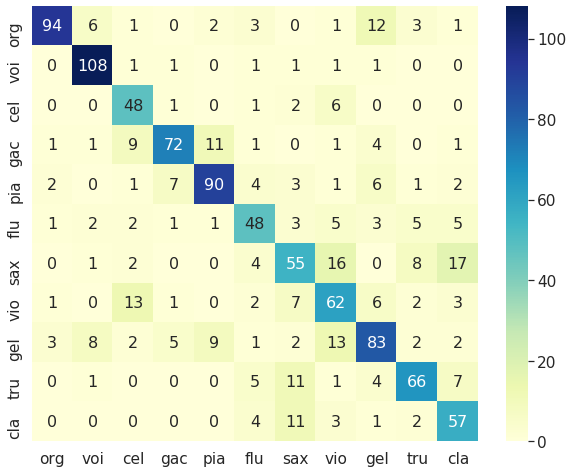

In [34]:
import seaborn as sn
import pandas as pd
#seaborn for heatmap of representation of the results from evaulation 
df_cm = pd.DataFrame(cm)
sn.set(font_scale=1.4)
plt.subplots(figsize=(10,8))
ax = sn.heatmap(df_cm, annot=True,fmt="g",xticklabels=get_class_names(),yticklabels=get_class_names(),annot_kws={"size": 16},cmap="YlGnBu")

'''

It can be observed in this particular case that:
 voice (voi) & organ (org) had highly accurate predictions
 while instruments like saxophone (sax) and violin (vio) suffered a couple of mistakes

-- this is completely arbitrary and it depends on the size of the class (no of samples in class)
  or the particular inclination of noise data in the dataset

'''

In [0]:
### TESTING THE REAL-TIME PART
!cp "drive/My Drive/TestingOut.zip" "TestingOut.zip"

In [36]:
!unzip 'TestingOut.zip'

Archive:  TestingOut.zip
   creating: TestingOut/
  inflating: TestingOut/02 bwv 1068 air on g string-10__cel.npy  
  inflating: TestingOut/02 bwv 1068 air on g string-11__cel.npy  
  inflating: TestingOut/02 bwv 1068 air on g string-12__cel.npy  
  inflating: TestingOut/02 bwv 1068 air on g string-13__cel.npy  
  inflating: TestingOut/02 bwv 1068 air on g string-14__cel.npy  
  inflating: TestingOut/02 bwv 1068 air on g string-15__cel.npy  
  inflating: TestingOut/02 bwv 1068 air on g string-1__cel.npy  
  inflating: TestingOut/02 bwv 1068 air on g string-2__cel.npy  
  inflating: TestingOut/02 bwv 1068 air on g string-3__cel.npy  
  inflating: TestingOut/02 bwv 1068 air on g string-4__cel.npy  
  inflating: TestingOut/02 bwv 1068 air on g string-5__cel.npy  
  inflating: TestingOut/02 bwv 1068 air on g string-6__cel.npy  
  inflating: TestingOut/02 bwv 1068 air on g string-7__cel.npy  
  inflating: TestingOut/02 bwv 1068 air on g string-8__cel.npy  
  inflating: TestingOut/02 bwv 106

In [37]:
import numpy as np
import os
classes = get_class_names()
print(classes)
def preprocess_data():
  folder = 'TestingOut/'
  
  files = os.listdir(folder)
  total_files = len(files)
  
  X = []
  Y = []
  for idx,val in enumerate(files):
    label = (val.split('__')[1]).split('.')[0]
    label = label.rstrip()
    aud = np.load(folder+val,allow_pickle=True)
    X.append(aud)
    Y.append(classes.index(label))
  
  
  return X,Y
    

['org', 'voi', 'cel', 'gac', 'pia', 'flu', 'sax', 'vio', 'gel', 'tru', 'cla']


In [0]:
X,Y_true = preprocess_data()

In [0]:
Y_true1 = np.array(Y_true)

In [44]:
Y_true1[:5]

array([5, 3, 6, 4, 3])

In [0]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 259, 64)      1664      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 42, 86, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 42, 86, 64)        256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 42, 86, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 42, 86, 64)        102464    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 28, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 28, 64)       

In [86]:
!unzip "project_testing.zip"

Archive:  project_testing.zip
   creating: project_testing/
  inflating: project_testing/flute_1.wav  
  inflating: project_testing/flute_2.wav  
  inflating: project_testing/guitar_1.wav  
  inflating: project_testing/guitar_2.wav  
  inflating: project_testing/piano_1.wav  
  inflating: project_testing/piano_2.wav  


In [98]:
'''
Modular real-time testing

1. snippets can be of any length (min 2sec to > 2-3 min)

2. predictions are made by splitting the audio file to base output size from the network

3. the final output is the culmination of multiple snippets - so the probability output isnt scaled to 1.0

4. it outputs top 3 instruments/voice in the audio

'''

#['org', 'voi', 'cel', 'gac', 'pia', 'flu', 'sax', 'vio', 'gel', 'tru', 'cla']
import math
import librosa
import librosa.display
sample1 = os.listdir('project_testing/')[0]

aud, sr = librosa.load('bach.wav', mono=mono,sr=None)
spect = librosa.feature.melspectrogram(y=aud,sr=sr,n_fft=1024,hop_length=512)
melgram = librosa.power_to_db(spect,ref=np.max)[np.newaxis,:,:,np.newaxis]
Y_pred = []
sample_len = model.layers[0].output_shape[2]
aud = np.load('AudPrep/voi/'+sample1,allow_pickle=True)
count = int(melgram.shape[2] // sample_len)
for i in range(count):
  windows = []
  windows.append(melgram[0,:,i*sample_len:(i+1)*sample_len,:])
  windows = np.array(windows)
  y_pred = model.predict(windows)
results = list(map(sum,zip(*y_pred)))
results = [ (i/count) for i in results]
ans = []
for i in range(len(classes)):
  ans.append((classes[i],results[i]))
ans = sorted(ans,key = lambda tup:tup[1],reverse=True)
top3 = [ i[0] for i in ans[0:3] ]
print(top3)

['cel', 'vio', 'gac']


In [47]:
#Testing Phase
print('Testing on {} samples'.format(Y_true1.shape[0]))

Y_pred = []
sample_len = model.layers[0].output_shape[2]
printevery = 50
for idx,val in enumerate(X):
  if idx%printevery == 0:
    print('Evaluated {} audio files'.format(idx))
  count = int(val.shape[2] // sample_len)
  for i in range(count):
    windows = []
    windows.append(val[0,:,i*sample_len:(i+1)*sample_len,:])
    windows = np.array(windows)
    y_pred = model.predict(windows)
  results = list(map(sum,zip(*y_pred)))
  results = [ i/count for i in results]
  final_index = results.index(max(results))
  Y_pred.append(final_index)

Testing on 766 samples
Evaluated 0 audio files
Evaluated 50 audio files
Evaluated 100 audio files
Evaluated 150 audio files
Evaluated 200 audio files
Evaluated 250 audio files
Evaluated 300 audio files
Evaluated 350 audio files
Evaluated 400 audio files
Evaluated 450 audio files
Evaluated 500 audio files
Evaluated 550 audio files
Evaluated 600 audio files
Evaluated 650 audio files
Evaluated 700 audio files
Evaluated 750 audio files
